In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

In [26]:
from pandarallel import pandarallel
pandarallel.initialize()
import matplotlib.pyplot as plt
from sklearn.metrics import auc

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
try:
    import AD_result_fetcher
except:
    from . import AD_result_fetcher

In [4]:
set_marked_positive = set()
set_marked_negative = set()
set_seen_records = set()

In [5]:
# =======================
# Baseline 1 
# =======================
DIR = 'us_import1'
PERCENTILE_THRESHOLD = 100
PERCENTILE_THRESHOLD = 100 - 10
REVEAL_STEP = 5
ID_COL = 'PanjivaRecordID'
company_attributes = ['ConsigneePanjivaID','ShipperPanjivaID']

def modify_score_v1(orig_score, num_matches):
    alpha = 0.75
    beta = 0.25
    max_matches = 2
    new_score = (alpha * orig_score + beta * (num_matches/max_matches))/(alpha + beta)
    return new_score

In [6]:
labelled_results = AD_result_fetcher.read_in_AD_result(DIR)

22935 22935


In [7]:
score_threshold = np.percentile(labelled_results['score'],PERCENTILE_THRESHOLD)
print(score_threshold)

0.4351421390699711


In [8]:
score_threshold = np.percentile(labelled_results['score'],PERCENTILE_THRESHOLD)

In [9]:
working_df = labelled_results.copy()
working_df['dynamic_score'] = labelled_results['score']

In [10]:
working_df.head(10)

,PanjivaRecordID,Carrier,ConsigneePanjivaID,HSCode,PortOfLading,PortOfUnlading,ShipmentDestination,ShipmentOrigin,ShipperPanjivaID,label,score,dynamic_score
5,1154884691001,245,4631,4912,5190,5288,5352,5514,9882,-1,1.000000,1.000000
490,11463423710011002,308,2615,5007,5129,5302,5360,5437,6194,1,0.998628,0.998628
22,1140462591001,435,2270,4910,5121,5264,5382,5460,6568,-1,0.995128,0.995128
523,11417637310011002,142,1622,4925,5185,5259,5383,5434,7826,1,0.990789,0.990789
631,11384327310011002,142,1567,4925,5185,5259,5377,5434,10184,1,0.990111,0.990111
281,1170694011001,245,4797,4912,5190,5283,5352,5456,11045,-1,0.987483,0.987483
365,1172173001001,142,4880,4925,5185,5259,5377,5434,7718,-1,0.981467,0.981467
80,1139183471001,193,2196,4952,5062,5279,5377,5502,7774,-1,0.977622,0.977622
105,1160867961001,142,2166,4925,5185,5259,5324,5503,9602,-1,0.976587,0.976587
173,1145017151001,245,4379,4912,5190,5270,5352,5434,7503,-1,0.973775,0.973775


In [11]:
working_df['PanjivaRecordID'] = working_df['PanjivaRecordID'].astype(int)
working_df['ConsigneePanjivaID'] = working_df['ConsigneePanjivaID'].astype(int)
working_df['ShipperPanjivaID'] = working_df['ShipperPanjivaID'].astype(int)

In [12]:
def process_1(new_df):
    global set_marked_negative
    global set_marked_positive
    global company_attributes
   
    def update_row(row):
        count = 0 
#         count = len(set(row[company_attributes].values.tolist()).intersection(set_marked_positive))
        for c in company_attributes:
            if row[c] in set_marked_positive: count+=1
        new_score = modify_score_v1(row['score'],count)  
        return new_score
    new_df['dynamic_score'] = new_df.parallel_apply(update_row,axis=1)
    return new_df

In [13]:
def execute_input(working_df, update_scores=False):
    global ID_COL
    global REVEAL_STEP
    global set_marked_positive
    global set_marked_negative
    
    actors = ['ConsigneePanjivaID','ShipperPanjivaID']
    
    top_results = working_df.head(REVEAL_STEP)
    cur_iter_ids = top_results[ID_COL].values.tolist()
    new_df = working_df.loc[~(working_df[ID_COL].isin(cur_iter_ids))]
    
    # positive labels (True Positives)
    pos = top_results.loc[top_results['label']==1]
    # negative labels ( False positives )
    neg = top_results.loc[top_results['label']!=1]
    num_correct = len(pos)
    precision = len(pos)/REVEAL_STEP
#     print('Precision ::', precision)
    for col in actors:
        set_marked_positive = set_marked_positive.union(set(pos[col]))
    for col in actors:
        set_marked_negative = set_marked_negative.union(set(neg[col]).difference(set_marked_positive))
    
    if update_scores:
        new_df = process_1(new_df)
        new_df = new_df.sort_values(by='dynamic_score',ascending=False)
    
    
    return new_df, precision, num_correct 

In [14]:


max_iter=len(working_df.loc[working_df['score']>=score_threshold])//REVEAL_STEP

In [15]:
precision_values_1 = []
cur_df = working_df.copy()

count = 0
cum_correct = [0]
num_revealed = [0]
while count < max_iter:
    cur_df, precision,correct = execute_input(cur_df)
    precision_values_1.append(precision)
    count +=1
    cum_correct.append(correct+cum_correct[-1])
    num_revealed.append(num_revealed[-1]+REVEAL_STEP)
cum_correct_1 = cum_correct[1:]
num_revealed_1 = num_revealed[1:]

In [16]:
precision_values_2 = []
cur_df = working_df.copy()
count= 0

cum_correct = [0]
num_revealed = [0]
while count < max_iter :
    cur_df, precision, correct = execute_input(cur_df,True)
    precision_values_2.append(precision)
    remaining = len(cur_df.loc[cur_df['label']==1])
    if remaining == 0: 
        break
    count +=1
    cum_correct.append(correct+cum_correct[-1])
    num_revealed.append(num_revealed[-1]+REVEAL_STEP)
cum_correct_2 = cum_correct[1:]
num_revealed_2 = num_revealed[1:]

/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [18]:
# plt.figure()
# plt.plot(np.arange(len(precision_values_1)),precision_values_1,'r')
# plt.plot(np.arange(len(precision_values_2)),precision_values_2,'b')
# plt.show()

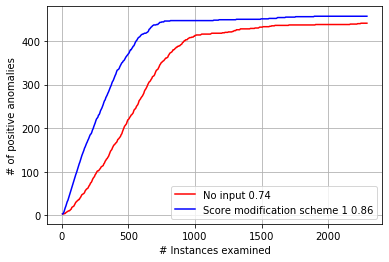

In [34]:
plt.figure()
plt.grid()
plt.xlabel('# Instances examined')
plt.ylabel('# of positive anomalies')
max_x = max(np.max(num_revealed_1),np.max(num_revealed_2))
max_y = max(np.max(cum_correct_1),np.max(cum_correct_2))
area = max_x*max_y
_auc1 = auc(num_revealed_1, cum_correct_1)/area
_auc2 = auc(num_revealed_2, cum_correct_2)/area
plt.plot(num_revealed_1,cum_correct_1,'r',label='No input {:.2f}'.format(_auc1))
plt.plot(num_revealed_2,cum_correct_2,'b',label='Score modification scheme 1 {:.2f}'.format(_auc2))
plt.legend()
plt.show()
# cum_correct = [0]
# num_revealed = [0]

22935